In [195]:
import numpy as np
import pandas as pd

import os
import json
from tqdm import tqdm

import lightgbm as lgb
import scipy as sp

from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder


In [196]:
RANDOM_STATE = 322

In [197]:
np.random.seed(RANDOM_STATE)

In [198]:
input_path = "../../input"

In [199]:
train_df = pd.read_csv(os.path.join(input_path, 'train/train.csv'))

In [200]:
test_df = pd.read_csv(os.path.join(input_path, 'test/test.csv'))

### Looking on label balance in dataset

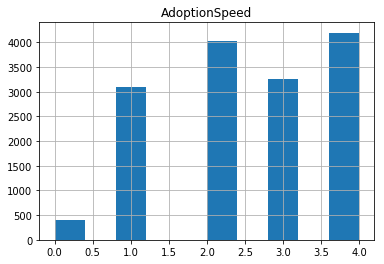

In [201]:
adoption_speed_hist = train_df.hist('AdoptionSpeed')

### Quadratic weighted kappa score

In [202]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

### Coefficients optimizer

In [203]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

### Generate features based on 'Name' ('No_name',  'Bad_name')

In [204]:
train_df['Name'] = train_df['Name'].fillna('No Name')
test_df['Name'] = test_df['Name'].fillna('No Name')

In [205]:
train_df['No_name'] = 0
train_df.loc[(train_df['Name'] == 'No Name') | 
             (train_df['Name'] == 'No Name Yet'), 'No_name'] = 1
test_df['No_name'] = 0
test_df.loc[(test_df['Name'] == 'No Name')| 
             (test_df['Name'] == 'No Name Yet'), 'No_name'] = 1

In [206]:
train_df['Bad_name'] = 0
train_df.loc[train_df['Name'].apply(lambda x: len(str(x))) < 3, 'Bad_name'] = 1

In [207]:
test_df['Bad_name'] = 0
test_df.loc[test_df['Name'].apply(lambda x: len(str(x))) < 3, 'Bad_name'] = 1

In [208]:
train_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,No_name,Bad_name
0,2,Nibble,3,299,0,1,1,7,0,1,...,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,0,0
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,1,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,0,0
3,1,Miko,4,307,0,2,1,2,0,2,...,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0,0
4,1,Hunter,1,307,0,1,1,0,0,2,...,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,0,0


### Add features from sentiment data

In [209]:
def add_sentiment_features(df, id_column_name, sent_dir):
    doc_sent_mag = []
    doc_sent_score = []
    not_found_count = 0
    
    for id in tqdm(df[id_column_name]):
        try:
            with open(os.path.join(sent_dir, id + '.json'), 'r') as f:
                sentiment = json.load(f)
            doc_sent_mag.append(sentiment['documentSentiment']['magnitude'])
            doc_sent_score.append(sentiment['documentSentiment']['score'])
        except Exception as e:
            not_found_count += 1
            doc_sent_mag.append(-1)
            doc_sent_score.append(-1)
    df.loc[:, 'doc_sent_mag'] = doc_sent_mag
    df.loc[:, 'doc_sent_score'] = doc_sent_score
    print("Number of all objects: {}".format(df.shape[0]))
    print("Not found: {}".format(not_found_count))
    return df

In [210]:
train_df = add_sentiment_features(train_df, 'PetID', input_path + '/train_sentiment')

100%|██████████| 14993/14993 [00:04<00:00, 3619.30it/s]

Number of all objects: 14993
Not found: 551


In [211]:
test_df = add_sentiment_features(test_df, 'PetID', input_path + '/test_sentiment')

100%|██████████| 3948/3948 [00:01<00:00, 3343.13it/s]

Number of all objects: 3948
Not found: 133


In [212]:
def add_image_metadata_features(df, id_column_name, metadata_dir):
    vertex_xs = []
    vertex_ys = []
    bounding_confidences = []
    bounding_importance_fracs = []
    dominant_blues = []
    dominant_greens = []
    dominant_reds = []
    dominant_pixel_fracs = []
    dominant_scores = []
    label_scores = []
    nf_count = 0
    nl_count = 0
    
    df_id = df[id_column_name]
    for pet in tqdm(df_id):
        try:
            with open(os.path.join(metadata_dir, pet + '-1.json'), 'r') as f:
                data = json.load(f)
            vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
            vertex_xs.append(vertex_x)
            vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
            vertex_ys.append(vertex_y)
            bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
            bounding_confidences.append(bounding_confidence)
            bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
            bounding_importance_fracs.append(bounding_importance_frac)
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
            dominant_blues.append(dominant_blue)
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
            dominant_greens.append(dominant_green)
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
            dominant_reds.append(dominant_red)
            dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
            dominant_pixel_fracs.append(dominant_pixel_frac)
            dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
            dominant_scores.append(dominant_score)
            if data.get('labelAnnotations'):
                label_score = data['labelAnnotations'][0]['score']
                label_scores.append(label_score)
            else:
                nl_count += 1
                label_scores.append(-1)
        except FileNotFoundError:
            nf_count += 1
            vertex_xs.append(-1)
            vertex_ys.append(-1)
            bounding_confidences.append(-1)
            bounding_importance_fracs.append(-1)
            dominant_blues.append(-1)
            dominant_greens.append(-1)
            dominant_reds.append(-1)
            dominant_pixel_fracs.append(-1)
            dominant_scores.append(-1)
            label_scores.append(-1)

    print(nf_count)
    print(nl_count)
    df.loc[:, 'vertex_x'] = vertex_xs
    df.loc[:, 'vertex_y'] = vertex_ys
    df.loc[:, 'bounding_confidence'] = bounding_confidences
    df.loc[:, 'bounding_importance'] = bounding_importance_fracs
    df.loc[:, 'dominant_blue'] = dominant_blues
    df.loc[:, 'dominant_green'] = dominant_greens
    df.loc[:, 'dominant_red'] = dominant_reds
    df.loc[:, 'dominant_pixel_frac'] = dominant_pixel_fracs
    df.loc[:, 'dominant_score'] = dominant_scores
    df.loc[:, 'label_score'] = label_scores
    return df

In [213]:
train_df = add_image_metadata_features(train_df, 'PetID', input_path + '/train_metadata')

100%|██████████| 14993/14993 [00:04<00:00, 3633.98it/s]

341
2


In [214]:
test_df = add_image_metadata_features(test_df, 'PetID', input_path + '/test_metadata')

100%|██████████| 3948/3948 [00:01<00:00, 3411.20it/s]

128
0


### Generate simple (without words embeddings) features based on 'Description'

In [215]:
def add_text_length(df, text_column='Description'):
    df[text_column+'Length'] = df[text_column].fillna(" ").apply(lambda x: len(x))
    return df

In [216]:
def add_number_of_words(df, text_column='Description'):
    df['NumberOfWords'] = df[text_column].fillna(" ").apply(lambda x: len(x.split()))
    return df

In [217]:
def add_average_word_length(df, text_length_col='DescriptionLength', number_of_words_col='NumberOfWords'):
    
    df['AverageWordLength'] = df[text_length_col] / df[number_of_words_col]
    df['AverageWordLength'] = df['AverageWordLength'].replace([np.inf, -np.inf], 0)
    return df

In [218]:
def add_simple_text_features(df, text_column='Description'):
    df = add_text_length(df, text_column)
    df = add_number_of_words(df, text_column)
    df = add_average_word_length(df, 'DescriptionLength', 'NumberOfWords')
    return df

In [219]:
train_df = add_simple_text_features(train_df)

In [220]:
test_df = add_simple_text_features(test_df)

### TF-IDF features from description

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [222]:
SVD_COMPONENTS = 120

train_desc = train_df.Description.fillna("none").values
test_desc = test_df.Description.fillna("none").values

tfv = TfidfVectorizer(min_df=3,  max_features=10000,
        strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
        stop_words = 'english')
    
# Fit TFIDF
tfv.fit(list(train_desc))
X_tf_idf =  tfv.transform(train_desc)
X_test_tf_idf = tfv.transform(test_desc)

svd = TruncatedSVD(n_components=SVD_COMPONENTS)
svd.fit(X_tf_idf)
# print(svd.explained_variance_ratio_.sum())
# print(svd.explained_variance_ratio_)
X_tf_idf = svd.transform(X_tf_idf)
X_tf_idf = pd.DataFrame(X_tf_idf, columns=['svd_{}'.format(i) for i in range(SVD_COMPONENTS)])
train_df = pd.concat((train_df, X_tf_idf), axis=1)
X_test_tf_idf = svd.transform(X_test_tf_idf)
X_test_tf_idf = pd.DataFrame(X_test_tf_idf, columns=['svd_{}'.format(i) for i in range(SVD_COMPONENTS)])
test_df = pd.concat((test_df, X_test_tf_idf), axis=1)

### Drop not-using features

In [223]:
# drop text features and hash id`s
drop_list = ['PetID', 
             'RescuerID', 
             'Description']

In [224]:
pet_id_test = test_df['PetID']

In [225]:
y = train_df['AdoptionSpeed']

In [226]:
X = train_df.drop(drop_list, axis=1)

In [227]:
# X = X.drop('AdoptionSpeed', axis=1)

In [228]:
X_test = test_df.drop(drop_list, axis=1)

### Select cat features

In [229]:
def get_column_indeces_from_names(df,name_list):
    indeces = []
    for name in name_list:
        indeces.append(df.columns.get_loc(name))
    return indeces

In [230]:
cat_feature_names = [
    'Type',
    'Breed1',
    'Breed2',
    'Gender',
    'Color1',
    'Color2',
    'Color3',
#     'Vaccinated',
#     'Dewormed',
#     'Sterilized',
    'Health',
    'State',
    'No_name',
    'Bad_name'
]

In [231]:
def one_hot_feature(df, encoder, cat_column_name):
    one_hot_arr = encoder.transform(df[cat_column_name].values.reshape(-1,1)).toarray()
    one_hot_df = pd.DataFrame(one_hot_arr, 
                              columns = [cat_column_name+"_"+str(int(i)) for i in range(one_hot_arr.shape[1])])
    df = pd.concat([df, one_hot_df], axis=1)
    df = df.drop([cat_column_name], axis=1)
    return df

In [232]:

# for feature in cat_feature_names:
#     one_hot_enc = OneHotEncoder()
#     values = X[feature].values.reshape(-1, 1).tolist() + X_test[feature].values.reshape(-1, 1).tolist()
#     one_hot_enc.fit(values)
#     X = one_hot_feature(X, one_hot_enc, feature)
#     X_test = one_hot_feature(X_test, one_hot_enc, feature)

In [233]:
X.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,svd_110,svd_111,svd_112,svd_113,svd_114,svd_115,svd_116,svd_117,svd_118,svd_119
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.012845,-0.015627,-0.010596,-0.006852,0.000457,0.025671,-0.021531,0.074332,-0.051983,0.075864
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.002697,0.048393,-0.055310,0.019588,0.015240,-0.046826,0.023132,0.078573,-0.021171,-0.032533
2,1,Brisco,1,307,0,1,2,7,0,2,...,-0.041545,0.007350,0.029583,-0.028565,0.003216,-0.035025,-0.062875,0.054596,-0.051385,-0.020745
3,1,Miko,4,307,0,2,1,2,0,2,...,0.005368,-0.020707,0.054453,-0.012310,0.002906,0.001098,-0.001144,-0.024058,-0.019064,-0.006620
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.046734,-0.032957,0.001860,0.011123,-0.041837,-0.001033,-0.016111,-0.004028,0.008625,-0.004540


In [234]:
X_test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,svd_110,svd_111,svd_112,svd_113,svd_114,svd_115,svd_116,svd_117,svd_118,svd_119
0,1,Puppy,2,307,0,1,1,0,0,2,...,-0.006423,0.001366,-0.012746,-0.017503,-0.016944,-0.028383,0.026395,0.005962,0.024403,-0.004923
1,2,London,24,266,0,1,2,7,0,2,...,0.027410,-0.018066,-0.029473,-0.023839,0.001116,0.030051,0.001376,0.001437,0.002930,-0.016338
2,2,Snowball,20,266,0,2,7,0,0,2,...,-0.020269,0.014531,0.038634,-0.020226,0.037579,-0.022691,-0.028332,-0.014153,0.022717,-0.003017
3,2,Malibu,5,266,252,2,1,6,7,2,...,0.041328,-0.053199,-0.036413,-0.015732,0.029373,0.049163,0.005736,-0.034549,-0.043008,-0.006494
4,1,Lala Girl,6,307,0,2,1,2,7,2,...,-0.011001,-0.037103,-0.032843,-0.076949,0.005368,-0.008383,-0.022268,0.011688,-0.021399,0.013594


### Create cd and pool

In [235]:
X = X.drop(['Name', 'AdoptionSpeed'], axis=1)

In [236]:
X.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,svd_110,svd_111,svd_112,svd_113,svd_114,svd_115,svd_116,svd_117,svd_118,svd_119
0,2,3,299,0,1,1,7,0,1,1,...,0.012845,-0.015627,-0.010596,-0.006852,0.000457,0.025671,-0.021531,0.074332,-0.051983,0.075864
1,2,1,265,0,1,1,2,0,2,2,...,0.002697,0.048393,-0.055310,0.019588,0.015240,-0.046826,0.023132,0.078573,-0.021171,-0.032533
2,1,1,307,0,1,2,7,0,2,2,...,-0.041545,0.007350,0.029583,-0.028565,0.003216,-0.035025,-0.062875,0.054596,-0.051385,-0.020745
3,1,4,307,0,2,1,2,0,2,1,...,0.005368,-0.020707,0.054453,-0.012310,0.002906,0.001098,-0.001144,-0.024058,-0.019064,-0.006620
4,1,1,307,0,1,1,0,0,2,1,...,0.046734,-0.032957,0.001860,0.011123,-0.041837,-0.001033,-0.016111,-0.004028,0.008625,-0.004540


In [237]:
X_test = X_test.drop(['Name'], axis=1)

In [248]:
def cross_val(X, y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=RANDOM_STATE)
    test_predictions = np.zeros((X_test.shape[0], 1))
    train_predictions = np.zeros((X.shape[0], 1))

    cv_results = []
    scores = []
    coefficients = np.zeros((n_splits, 4))
    fold = 0
    for tr_ind, val_ind in skf.split(X, y):
        X_train = X.loc[tr_ind]
        y_train = y.loc[tr_ind]
        
        X_valid = X.loc[val_ind]
        y_valid = y.loc[val_ind]
        
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'learning_rate': 0.005,
            'subsample': .8,
            'colsample_bytree': 0.8,
            'min_split_gain': 0.006,
            'min_child_samples': 150,
            'min_child_weight': 0.1,
            'max_depth': 20,
            'n_estimators': 10000,
            'num_leaves': 80,
            'silent': -1,
            'verbose': -1,
            'random_state': RANDOM_STATE
        }
        
        model = lgb.LGBMRegressor(**lgb_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse',
            verbose=200,
            early_stopping_rounds=100
        )
        
        y_pred = model.predict(X_valid, num_iteration=model.best_iteration_)
#         y_pred = list(map(lambda x: int(x[0]), y_pred))
        test_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        test_predictions += test_pred.reshape(-1, 1)
        
        train_predictions[val_ind] = y_pred.reshape(-1, 1)

        
        optR = OptimizedRounder()
        optR.fit(y_pred, y_valid.values)
        coefficients[fold, :] = optR.coefficients()
        
        pred = optR.predict(y_pred, coefficients[fold, :])
        
        kappa_scr = quadratic_weighted_kappa(y_valid, pred)
        
        print("Fold = {}. QWK = {}. Coef = {}".format(fold, kappa_scr, coefficients[fold,:]))
        cv_result = {}
        cv_result['Fold'] = fold
        cv_result['Model'] = model
        cv_result['QWK'] = kappa_scr
        cv_result['Coef'] = coefficients[fold, :]
        cv_results.append(cv_result)
        scores.append(kappa_scr)
        fold += 1
    print('Average: {}'.format(sum(scores)/n_splits))
    test_predictions = test_predictions * 1./n_splits

    return {
            'train_predictions': train_predictions,
            'predictions': test_predictions,
            'coefficients': np.mean(coefficients, axis=0)
        }

In [249]:
results = cross_val(X, y, n_splits = 3)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.10193	valid_0's l2: 1.21425
[400]	valid_0's rmse: 1.07841	valid_0's l2: 1.16297
[600]	valid_0's rmse: 1.06791	valid_0's l2: 1.14043
[800]	valid_0's rmse: 1.0611	valid_0's l2: 1.12593
[1000]	valid_0's rmse: 1.0566	valid_0's l2: 1.1164
[1200]	valid_0's rmse: 1.05368	valid_0's l2: 1.11023
[1400]	valid_0's rmse: 1.05188	valid_0's l2: 1.10644
[1600]	valid_0's rmse: 1.05048	valid_0's l2: 1.1035
[1800]	valid_0's rmse: 1.04931	valid_0's l2: 1.10105
[2000]	valid_0's rmse: 1.04838	valid_0's l2: 1.0991
[2200]	valid_0's rmse: 1.04799	valid_0's l2: 1.09828
[2400]	valid_0's rmse: 1.04772	valid_0's l2: 1.09771
[2600]	valid_0's rmse: 1.04733	valid_0's l2: 1.09691
[2800]	valid_0's rmse: 1.04689	valid_0's l2: 1.09597
[3000]	valid_0's rmse: 1.04641	valid_0's l2: 1.09497
[3200]	valid_0's rmse: 1.04605	valid_0's l2: 1.09423
[3400]	valid_0's rmse: 1.0457	valid_0's l2: 1.09349
[3600]	valid_0's rmse: 1.04551	valid_0's l2: 1

In [181]:
print(results['predictions'])

[[1.79588282]
 [2.93990883]
 [2.92158327]
 ...
 [1.41564543]
 [1.87354248]
 [2.70175199]]


In [182]:
optR = OptimizedRounder()

In [183]:
train_predictions = np.array(list(map(lambda x: x[0], results['train_predictions'])))

In [184]:
optR.fit(train_predictions, y)

In [185]:
coefficients = optR.coefficients()

In [186]:
coefficients

array([0.47835911, 2.07812264, 2.50880788, 2.83760833])

In [187]:
predictions = optR.predict(results['predictions'], coefficients).astype(int)


In [188]:
predictions = list(map(lambda x: x[0], predictions))

In [189]:
predictions

[1,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 1,
 4,
 1,
 4,
 2,
 4,
 4,
 3,
 4,
 2,
 4,
 2,
 3,
 1,
 4,
 4,
 3,
 1,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 2,
 2,
 3,
 4,
 1,
 3,
 3,
 4,
 2,
 4,
 1,
 2,
 4,
 2,
 4,
 4,
 4,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 2,
 2,
 4,
 3,
 2,
 4,
 3,
 4,
 3,
 3,
 1,
 4,
 4,
 3,
 2,
 3,
 3,
 4,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 3,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 3,
 4,
 4,
 2,
 3,
 4,
 2,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 2,
 4,
 4,
 3,
 4,
 3,
 4,
 3,
 2,
 2,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 3,
 4,
 3,
 2,
 4,
 2,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 1,
 4,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 4,
 4,
 2,
 4,
 3,


In [190]:
submit_df = pd.read_csv(os.path.join(input_path, 'test/sample_submission.csv'))


In [191]:
submit_df.AdoptionSpeed = predictions


In [192]:
submit_df.AdoptionSpeed.value_counts()

2    1225
4    1042
3     909
1     772
Name: AdoptionSpeed, dtype: int64

In [193]:
submit_df.head()

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,3
4,43fbba852,4


In [194]:
submit_df.to_csv('submission.csv', index=False)